# Sampling Subnetworks via Gumbel-Softmax
- To get a feel about how to implement Gumbel-Softmax related methods and what limitations they have.
- I won't go into the motivation, plety of that around the internet
- First Gumbel-Softmax: what it looks like (noise, resulting class distributions) and how to implement it (straight through estimator).
- Second, a small example training to show how to patch a model and play around with hyper-parameters.

# Gumbel Noise
- For the reparametrisation trick we want to sample noise from Gumbel(0, 1) = $e^{-e^{-x}}$
- We do this via the inverse CDF method - sampling from U(0,1) and transforming those percentiles into X ~ G(0, 1)
- Gumbel Inverse CDF = $-\log(-\log(U))$

In [1]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['text.usetex'] = True

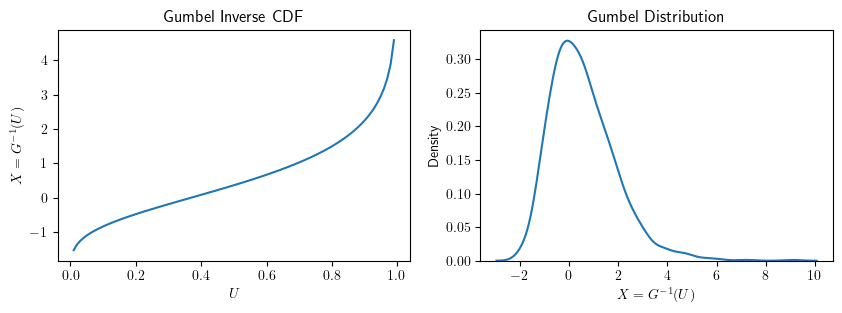

In [2]:
fig, axarr = plt.subplots(1, 2, figsize=(10, 3))

G = lambda x: -torch.log(-torch.log(x))

axarr[0].set_title("Gumbel Inverse CDF")
axarr[0].set_xlabel("$U$")
axarr[0].set_ylabel(r"$X = G^{-1}(U)$")
x = torch.linspace(0, 1, 100)
axarr[0].plot(x, G(x))

axarr[1].set_title("Gumbel Distribution")
axarr[1].set_xlabel(r"$X = G^{-1}(U)$")
sns.kdeplot(G(torch.rand(1000)), ax=axarr[1])
plt.show()

# Gumbel-Softmax Sampling
- We want to sample from a categorical distribution C1, C2 ~ Categorical($\pi_1, \pi_2$) given logits $\alpha_1, \alpha_2$
- Where $\pi_1 = \frac{\alpha_1}{\alpha_1 +\alpha_2}$, and $\pi_2 = 1 - \pi_1$, such that $P(C_1) = \pi_1$
- To keep $\alpha_1$ and $\alpha_2$ differentiable we use the reparametrisation trick together with softmax
    - By adding $G(0, 1)$ noise to the log(logits) and then softmax we obtain soft samples from Categorical($\pi_1, \pi_2$)
- Note: softmax is to make it differentiable for the backward pass, for the forward pass we don't want anything soft - we need a one-hot encoding (see straight through estimator)
- Softmax has a temperature parameter $\tau$ which controls the entropy of the resulting distribition
    - Small values of $\tau$ behaves like argmax (which is what we want), high values blur the distribution to the point that it becomes uniform
- The soft probability of C1 being sampled is $\tilde{\pi_1} = \frac{e^{((\log(\alpha_1) + g_1)\tau^{-1}}}{e^{(\log(\alpha_1) + g)\tau^{-1}} + e^{(\log(\alpha_2) + g_2)\tau^{-1}}}$, where $g1, g2 \sim G(0, 1)$
- Note: Using probabilities $\pi_1$ intead of logits $\alpha_1$ does not affect the resulting distribution as long as relative proportions are kept
- Simulation for different $\pi_1$ and $\tau$
    - At the end of the day we are interested in a categorical distribution, so sampling should ideally result in either the C1 or C2
    - This means $\tilde\pi_1$ is either 1 or 0 for a given sample. And for multiple samples the proportion of 0s and 1s should be $\pi_1$
    - For $\tau = 0.1$ we see that $\tilde \pi_1$ is correctly sampled $P(\tilde \pi_1=1)=\pi_1$
    - For larger $\tau$ we move away from a categorical distribution and obtain $\tilde \pi_1 \in [0, 1]$
    - This is not a dealbreaker as long as $P(C_1) = P(\tilde \pi_1 > 0.5) = \pi_1$, which is true even for larger $\tau$
    - Note: In this example $\lim_{\tau \rightarrow \infty}  \tilde \pi_1= .5$ and $\tau$ increases, which is the uniform distribution over C1 and C2

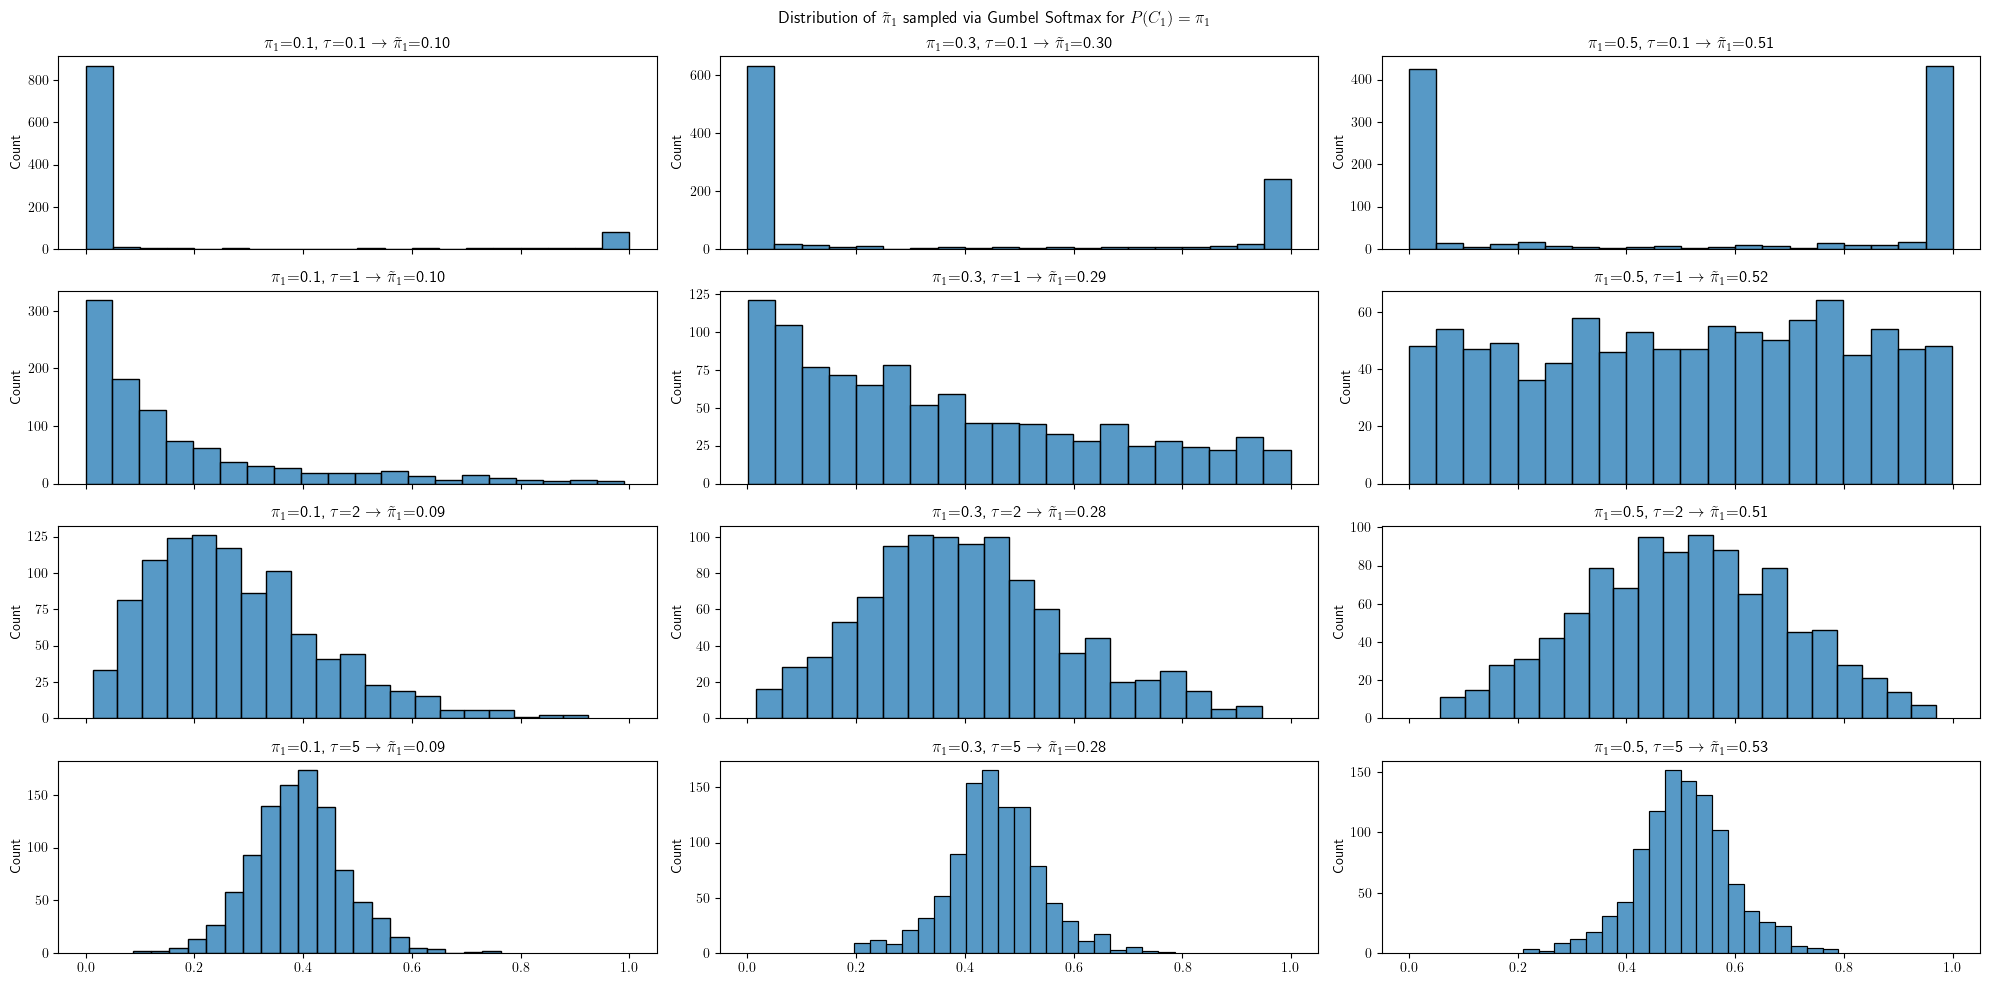

In [3]:
def gumbel_softmax_sample(logits: float, temperature: float = 1, size=1000):
    gumbel_noise = -torch.log(-torch.log(torch.rand(size, len(logits))))
    y = logits.log() + gumbel_noise
    return torch.nn.functional.softmax(y / temperature, dim=-1)


probas = [0.1, 0.3, 0.5]
temps = [0.1, 1, 2, 5]

fig, axarr = plt.subplots(len(temps), len(probas), figsize=(20, 10), sharey=False, sharex=True)
fig.suptitle("Distribution of $\\tilde \\pi_1$ sampled via Gumbel Softmax for $P(C_1)=\\pi_1$")

for ax_i, temp in enumerate(temps):
    for ax_j, proba in enumerate(probas):
        logits = torch.tensor([proba, 1 - proba])
        x = gumbel_softmax_sample(logits, temp)
        sns.histplot(x[:, 0], ax=axarr[ax_i, ax_j], bins=20)
        axarr[ax_i, ax_j].set_title(f"$\\pi_1$={proba}, $\\tau$={temp} $\\rightarrow$ $\\tilde \\pi_1$={(x[:, 0] > 0.5).float().mean():.2f}")
plt.tight_layout()

# Straight Through Estimator
- We use the Gumbel-Softmax trick to obtain differentiable categorical samples but for larger $\tau$ the samples are soft probabilities rather than an indicator
- We can still get categorical samples by using argmax, and then use the soft probability only in the backward pass for the gradients
- To implement this we can extend the autograd.Function class and implement `forward` and `backward`
- An easier approach is to use the `.detach` along with some computational graph arithmetic: `x - x.detach() = 0` however it allows for gradients to be computed

In [4]:
def straight_through(probas) -> torch.Tensor:
    y_hard = torch.zeros_like(probas)
    y_hard.scatter_(-1, torch.argmax(probas, dim=-1, keepdim=True), 1.0) # one-hot
    y = y_hard.detach() + (probas - probas.detach())
    return y


params = torch.tensor([0.1, 0.9], requires_grad=True)
print("Params we want to optimize:", params)
probas = gumbel_softmax_sample(params, temperature=5, size=1) # 
print("Sampled class probas from params:", probas)
y = straight_through(probas)
print("One-hot sample:", y)
y.sum().backward()
print("Gradient of params:", params.grad)

Params we want to optimize: tensor([0.1000, 0.9000], requires_grad=True)
Sampled class probas from params: tensor([[0.4385, 0.5615]], grad_fn=<SoftmaxBackward0>)
One-hot sample: tensor([[0., 1.]], grad_fn=<AddBackward0>)
Gradient of params: tensor([5.2269e-08, 7.4378e-09])


# Subnetwork Sampling
- Sample a policy using the learnable logits and then extract a subnetwork
- An option is at filter-level such as Stochastic Filter Groups (Bragman 2019), Max Roaming Networks (Pascal 2021)
- Generate a binary mask setting activations to 0 for filters that have not been sampled
- Easiest is to wrap conv layers with the additional logits and masked forward
- In this example we use 2 logits per filter keep/drop, which makes it a learnable dropout rather than multi-task partitioning
- Note: In practice this is fairly tricky to train, requiring (some or all): right init, warmup, temperature schedule, alternating network params and logit updates, batchnorm stats modification.

In [5]:
from torch import nn
from torch.nn import functional as F
from torchvision.models.resnet import resnet18

class GSMaskedConv(nn.Module):
    def __init__(self, conv, temperature=1, keep_ratio=0.5):
        super(GSMaskedConv, self).__init__()
        self.conv = conv
        self.alphas = nn.Parameter(torch.ones(conv.out_channels, 2), requires_grad=True)
        self.alphas.data[:, 0] = torch.tensor(keep_ratio).log()
        self.alphas.data[:, 1] = torch.tensor(1 - keep_ratio).log()
        self.temperature = temperature

    def forward(self, x):
        x = self.conv(x)
        mask = F.gumbel_softmax(self.alphas, tau=self.temperature, hard=True)
        mask = mask[:, 0].view(1, -1, 1, 1)
        return x * mask

In [6]:
# Test the GSMaskedConv with 5 filters
layer = GSMaskedConv(nn.Conv2d(5, 5, 1), temperature=1, keep_ratio=0.8)
out = layer(torch.randn(1, 5, 1, 1)).flatten()
print("Masked Filters:", out == 0 )

out.sum().backward()
print("Grads:", layer.alphas.grad[:, 0])

Masked Filters: tensor([ True,  True, False,  True, False])
Grads: tensor([-0.0183,  0.0084,  0.0194, -0.0259,  0.1069])


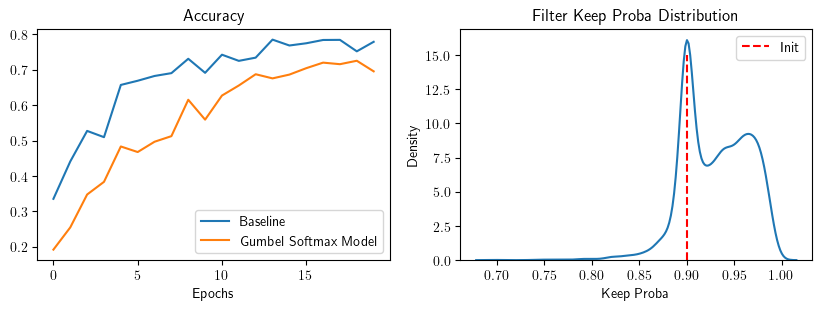

In [7]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchmetrics import Accuracy

def get_model():
    model = resnet18()
    model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    model.maxpool = nn.Identity()
    model.fc = nn.Linear(512 * model.layer1[0].expansion, 10)
    return model

def patch_model(model, temperature=1, keep_ratio=0.5):
    for name, m in model.named_children():
        if isinstance(m, nn.Conv2d):
            setattr(model, name, GSMaskedConv(m, temperature, keep_ratio))
            continue
        patch_model(m, temperature, keep_ratio)

def evaluate(model):
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    test_ds = torchvision.datasets.CIFAR10(root='/data/datasets/CIFAR10', train=False, transform=transform)
    test_loader = DataLoader(test_ds, batch_size=1024, shuffle=False)

    acc = Accuracy(task="multiclass", num_classes=10).cuda()
    model.eval()
    with torch.no_grad():
        for X, y in test_loader:
            outs = model(X.cuda())
            acc(outs, y.cuda())
    model.train()
    return acc.compute().cpu().item()

def train(model, epochs=20):
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    train_ds = torchvision.datasets.CIFAR10(root='/data/datasets/CIFAR10', train=True, transform=transform)
    train_loader = DataLoader(train_ds, batch_size=1024, shuffle=True)

    criterion = nn.CrossEntropyLoss()
    optimiser = torch.optim.Adam(model.parameters(), lr=1e-2)

    logs = []

    for _ in range(epochs):
        for X, y in train_loader:
            outs = model(X.cuda())
            loss = criterion(outs, y.cuda())

            optimiser.zero_grad()
            loss.backward()
            optimiser.step()
        logs.append(evaluate(model))
    return logs

def get_probas(model):
    probas = []
    for m in model.modules():
        if isinstance(m, GSMaskedConv):
            probas.append(m.alphas.softmax(dim=-1)[:,0])
    return torch.cat(probas)

gs_model = get_model()
patch_model(gs_model, temperature=1, keep_ratio=0.9)
gs_logs = train(gs_model.cuda(), epochs=20)

baseline_model = get_model()
baseline_logs = train(baseline_model.cuda(), epochs=20)



fig, axarr = plt.subplots(1, 2, figsize=(10, 3))

axarr[0].set_title("Accuracy")
axarr[0].set_xlabel("Epochs")
axarr[0].plot(baseline_logs, label="Baseline")
axarr[0].plot(gs_logs, label="Gumbel Softmax Model")
axarr[0].legend()

axarr[1].set_title("Filter Keep Proba Distribution")
sns.kdeplot(get_probas(gs_model).detach().cpu(), ax=axarr[1])
axarr[1].vlines(0.9, 0, 15, color='red', linestyle='--', label="Init")
axarr[1].set_xlabel("Keep Proba")
axarr[1].legend()